<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Общий-анализ-данных" data-toc-modified-id="Общий-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Общий анализ данных</a></span></li><li><span><a href="#Подбор-гиперпараметров-и-выбор-моделей" data-toc-modified-id="Подбор-гиперпараметров-и-выбор-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подбор гиперпараметров и выбор моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><code>LinearRegression</code></a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><code>RandomForestRegressor</code></a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span><code>CatBoostRegressor</code></a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» хочет привлекать больше водителей в период пиковой нагрузки. 

---

**КОНТЕКСТ ИССЛЕДОВАНИЯ:** исторические данные о заказах такси в аэропортах.

---

**ЦЕЛЬ ИССЛЕДОВАНИЯ:** построить модель для прогноза количества заказов такси на следующий час.

---

**ПЛАН ИССЛЕДОВАНИЯ**:

- Загрузить данные и изучить общую информацию о данных
- Выполнить ресемплирование данных по часу
- Проанализировать данные (на тренды, сезонность и шумы)
- Подготовить данные для ML
- Обучить разные модели с различными гиперпараметрами.
- Выбрать лучшую модель и проверить ее качество на тестовой выборке

---

**КРИТЕРИИ УСПЕХА И ПРИМЕЧАНИЯ:**

- Значение метрики *RMSE* на тестовой выборке должно **быть не больше 48**

---

**Описание данных для первого исследования:**

- *Данные:*  `/datasets/taxi.csv` 

*Количество заказов находится в столбце `num_orders`*

## Загрузка и подготовка данных

In [1]:
!pip install phik
!pip install shap
!pip install lightgbm
!pip install catboost
!pip install -U scikit-learn
!pip install -U statsmodels

import warnings
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

# Настройки pandas для отображения данных
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

# Игнорируем предупреждения
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Загружаем датасет
try:
    data_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

except:
    data_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Напишем функцию для получения общей информации о датасете
def get_info(data):
    """
    Функция выводит основную информацию о датасете: первые 5 строк, общую информацию, основные статистики,
    количество явных дубликатов и количество пропусков

    Args:
        data -> pandas.DataFrame: Датасет 

    Returns:
        None

    """
    data.sort_index(inplace=True)
    display(data.head())
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('-----')
    print('Кол-во пропусков:\n', data.isna().sum())
    print('-----')

In [4]:
get_info(data_taxi)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0



-----
Кол-во пропусков:
 num_orders    0
dtype: int64
-----


---
- В данных представлена информация о 26496 поездках 
- Данные представлены за промежуток с 1 марта 2018 года (0:00) по 31 августа 2018 года (23:50)
- Пропущенных значений не обнаружено
- С типами данных все в порядке

---

*Можем приступить к ресемплированию данных по часам (поскольку заказчик просит предсказания на следующий час)*

---

In [5]:
# Проверка на монотонность
data_taxi.index.is_monotonic_increasing

True

In [6]:
# Ресемплируем данные по часу
data_taxi = data_taxi.resample('1H').sum()

## Общий анализ данных

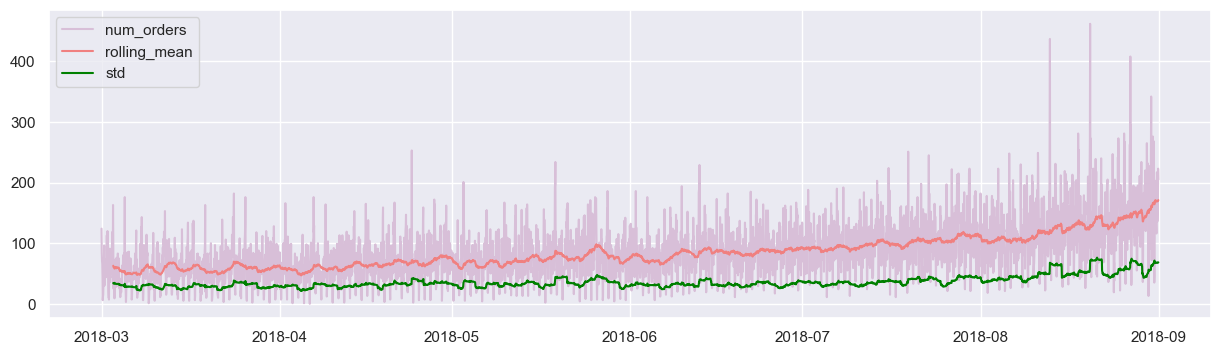

In [7]:
# Выставим размер для графиков
sns.set(rc={'figure.figsize': (15, 4)})

# Построим общий график для данных
plt.plot(data_taxi['num_orders'], label='num_orders', color='thistle')
plt.plot(data_taxi['num_orders'].rolling(50).mean(), label='rolling_mean', color='lightcoral')
plt.plot(data_taxi['num_orders'].rolling(50).std(), label='std', color='green')
plt.legend()
plt.show()

---
Определенно стоит рассмотреть данные на промежутках поменьше, а также рассмотреть наличие трендов / сезонности

---

In [8]:
# Напишем функцию для построения графика
def plotting(data, title):
    sns.lineplot(data=data, color='magenta').set_title(title)
    plt.show()

In [9]:
# Декомпозируем наши данные
decomposed_taxi = seasonal_decompose(data_taxi)

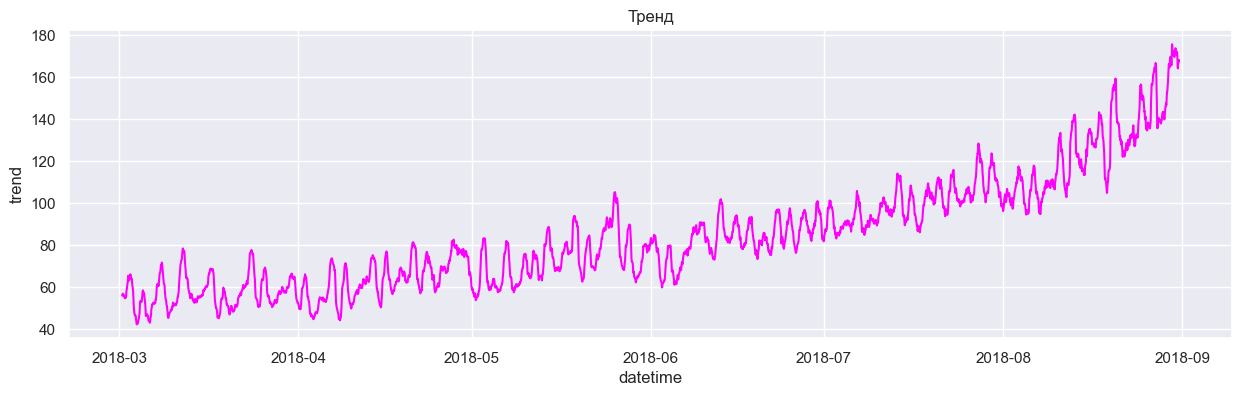

In [10]:
# Строим график трендов
plotting(decomposed_taxi.trend, 'Тренд')

---
- Наблюдаем тренд на повышение количества заказов к августу: вероятно, летом чаще люди летают куда-либо, в связи с чем заказы в аэропорты растут! 

---

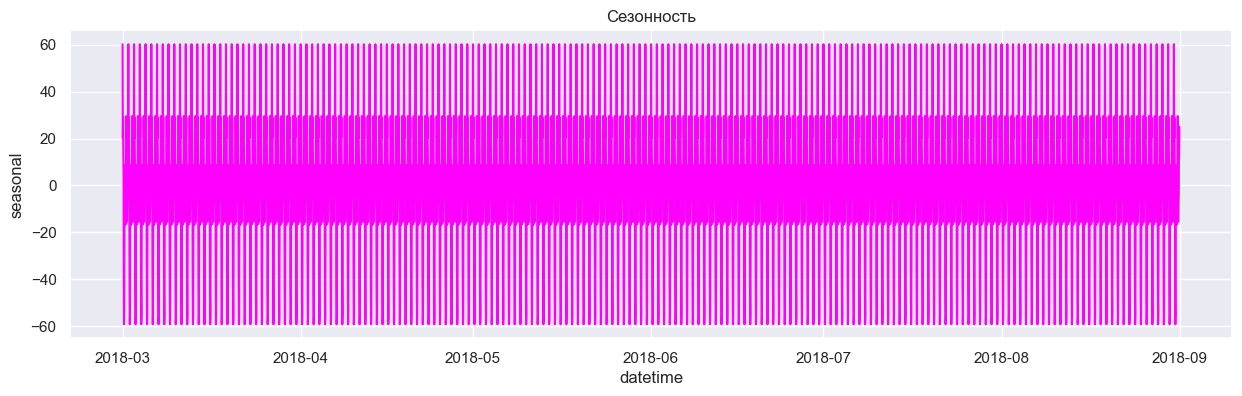

In [11]:
# Строим график сезонности
plotting(decomposed_taxi.seasonal, 'Сезонность')

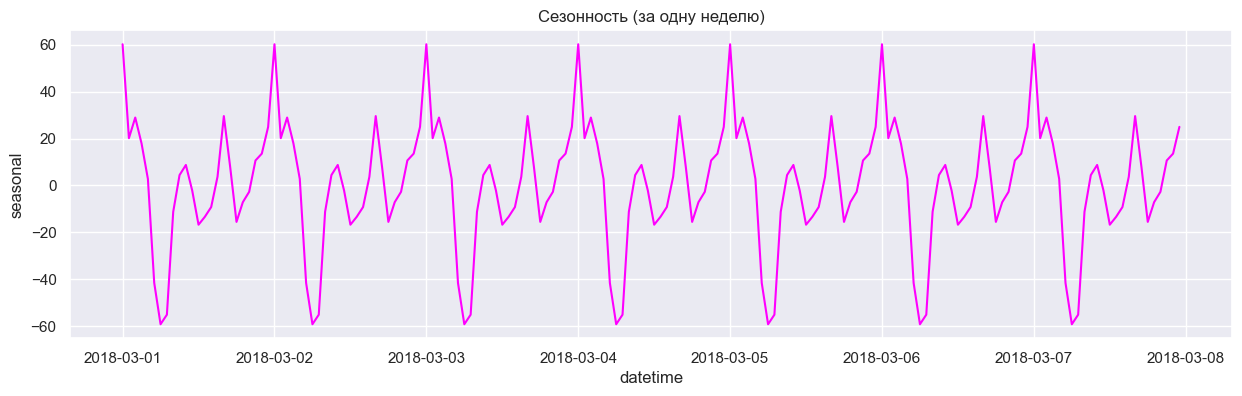

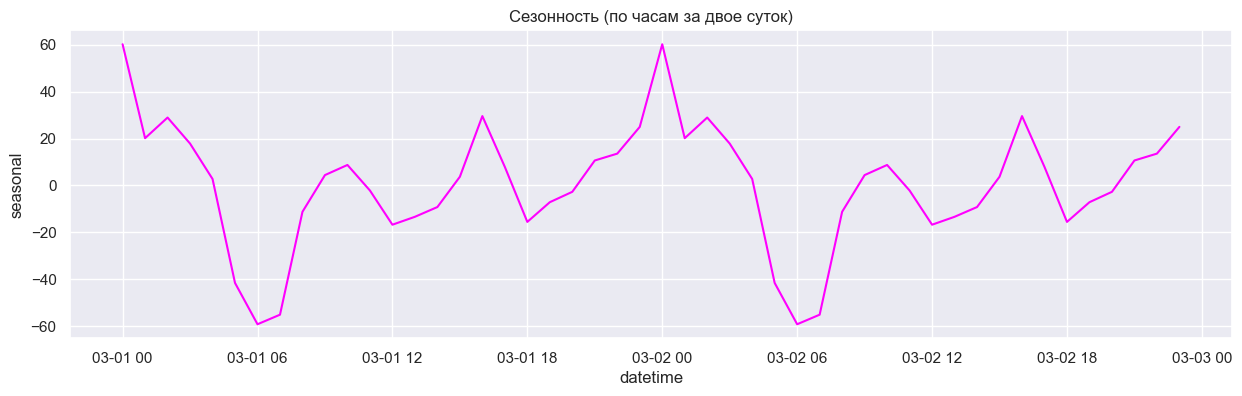

In [12]:
# Рассмотрим график сезонности поближе
plotting(decomposed_taxi.seasonal['2018-03-01':'2018-03-07'], 'Сезонность (за одну неделю)')
plotting(decomposed_taxi.seasonal['2018-03-01':'2018-03-02'], 'Сезонность (по часам за двое суток)')

---
- Минимальное количество заказов ~ в 06:00
- Максимальное количество заказов ~ в 00:00 
- В течение дня количество заказов примерно среднее, небольшое повышение к вечеру в 16-17 часов. 

---

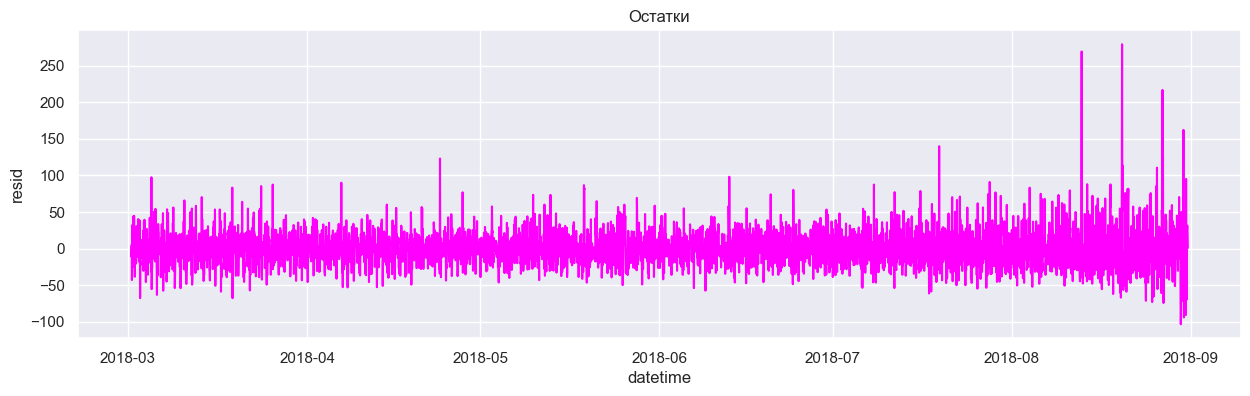

In [13]:
# Построим график остатков (шумов)
plotting(decomposed_taxi.resid, 'Остатки')

## Подбор гиперпараметров и выбор моделей

In [14]:
# Создадим функцию, которая добавляет признаки для обучения модели 
def make_features(df, max_lag, rolling_mean_size):
    """
    Функция получает на вход оригинальный датафрейм и возвращает датафрейм с новыми признаками
    
    :param data (pd.DataFrame): Оригинальный датафрейм 
    :param max_lag(int): Максимальное предыдущее значение временного ряда
    :param rolling_mean_size(int): Значение ширины скользящего окна
    :return(pd.DataFrame): Датафрейм с новыми признаками 
    """
    data_copy = df.copy(deep=True)
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour

    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_copy.dropna(inplace=True)

    return data_copy

In [15]:
# Создадим датасет для обучения моделей
data_ml = make_features(data_taxi, 180, 180)
display(f'Размер оригинального датасета: {data_taxi.shape}')
display(f'Размер обновленного датасета: {data_ml.shape}')

/var/folders/kp/shm6g1fn33g9t3hks97hfqjr0000gn/T/ipykernel_23310/1790687789.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)
/var/folders/kp/shm6g1fn33g9t3hks97hfqjr0000gn/T/ipykernel_23310/1790687789.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)
/var/folders/kp/shm6g1fn33g9t3hks97hfqjr0000gn/T/ipykernel_23310/1790687789.py:18: PerformanceWarning: DataFrame is highly fragmented.  Th

'Размер оригинального датасета: (4416, 1)'

'Размер обновленного датасета: (4236, 186)'

In [16]:
# Подготовим обучающую и тестовую выборки
RANDOM_STATE = 42
TEST_SIZE = 0.1

# Разбиваем фичи и таргет
X = data_ml.drop('num_orders', axis=1)
y = data_ml['num_orders']

# Разбиваем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

# Проверим корректность разбивки и утечку в тестовой выборке
print('---')
print('ФИЧИ')
print('---')
print(f'Временной промежуток обучающей выборки: {X_train.index.min()}, {X_train.index.max()}')
print(f'Временной промежуток тестовой выборки: {X_test.index.min()}, {X_test.index.max()}')
print('---')
print('ТАРГЕТ')
print('---')
print(f'Временной промежуток обучающей выборки: {y_train.index.min()}, {y_train.index.max()}')
print(f'Временной промежуток тестовой выборки: {y_test.index.min()}, {y_test.index.max()}')

---
ФИЧИ
---
Временной промежуток обучающей выборки: 2018-03-08 12:00:00, 2018-08-14 07:00:00
Временной промежуток тестовой выборки: 2018-08-14 08:00:00, 2018-08-31 23:00:00
---
ТАРГЕТ
---
Временной промежуток обучающей выборки: 2018-03-08 12:00:00, 2018-08-14 07:00:00
Временной промежуток тестовой выборки: 2018-08-14 08:00:00, 2018-08-31 23:00:00


### `LinearRegression`

In [17]:
# Создадим пустой список для моделей, RMSE на CV и RMSE на обучающей выборке
models = []

In [18]:
%%time

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
cv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(
    lin_reg,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

rmse_cv_lin_reg = (-1) * (sum(scores) / len(scores))
print(f'RMSE LinearRegression на кросс-валидации: {rmse_cv_lin_reg}')

y_pred_lin_reg = lin_reg.predict(X_train)
rmse_train_lin_reg = mean_squared_error(y_train, y_pred_lin_reg, squared=False)
print(f'RMSE LinearRegression на тренировочной выборке: {rmse_train_lin_reg}')
print('---')

models.append([lin_reg, rmse_cv_lin_reg, rmse_train_lin_reg])

RMSE LinearRegression на кросс-валидации: 22.83923964275242
RMSE LinearRegression на тренировочной выборке: 20.326704881580877
---
CPU times: user 331 ms, sys: 210 ms, total: 540 ms
Wall time: 909 ms


### `RandomForestRegressor`

In [19]:
%%time

rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

rf_params = {
    'n_estimators': range(50, 100, 10),
    'max_depth': range(5, 20, 5),
}

rf_grid = RandomizedSearchCV(
    rf_model,
    rf_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    cv=cv,
    verbose=5,
    random_state=RANDOM_STATE
)

rf_grid.fit(X_train, y_train)
rf = rf_grid.best_estimator_
rmse_cv_rf = (-1) * rf_grid.best_score_
print(f'Лучшая модель: \n {rf}')
print(f'RMSE RandomForestRegressor на кросс-валидации {rmse_cv_rf}')

y_pred_rf = rf.predict(X_train)
rmse_train_rf = mean_squared_error(y_train, y_pred_rf, squared=False)
print(f'RMSE RandomForestRegressor на тренировочной выборке: {rmse_train_rf}')
print('---')

models.append([rf, rmse_cv_rf, rmse_train_rf])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшая модель: 
 RandomForestRegressor(max_depth=15, n_estimators=90, random_state=42)
RMSE RandomForestRegressor на кросс-валидации 23.042539209387463
RMSE RandomForestRegressor на тренировочной выборке: 8.627244062438493
---
CPU times: user 21.9 s, sys: 150 ms, total: 22 s
Wall time: 1min 10s


### `CatBoostRegressor`

In [20]:
%%time
catboost_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
catboost_model.fit(X_train, y_train)

catboost_scores = cross_val_score(
    catboost_model,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

cv_score_catboost = sum(catboost_scores) / len(catboost_scores)
rmse_cv_catboost = (-1) * cv_score_catboost
print(f'RMSE на кросс-валидации :{rmse_cv_catboost}')

y_pred_catboost = catboost_model.predict(X_train)
rmse_train_catboost = mean_squared_error(y_train, y_pred_catboost, squared=False)
print(f'RMSE на тренировочной выборке: {rmse_train_catboost}')
print('---')

models.append([catboost_model, rmse_cv_catboost, rmse_train_catboost])

RMSE на кросс-валидации :22.709168766606076
RMSE на тренировочной выборке: 8.670260142348218
---
CPU times: user 27.6 s, sys: 2.97 s, total: 30.5 s
Wall time: 17.3 s


### Анализ моделей


In [21]:
models_analysis = pd.DataFrame(models, columns=['model', 'RMSE_cv', 'RMSE_train'])
models_analysis.sort_values('RMSE_cv')

,model,RMSE_cv,RMSE_train
2,<catboost.core.CatBoostRegressor object at 0x2...,22.709169,8.670260
0,LinearRegression(),22.839240,20.326705
1,"(DecisionTreeRegressor(max_depth=15, max_featu...",23.042539,8.627244


---

- Все модели показывают очень близкие результаты на кросс-валидации:
    - `LinearRegression` ->  RMSE == *22.839240*
    -  `CatBoostRegressor` -> RMSE ==  22.709169
    - `RandomForestRegressor` -> RMSE == 23.042539

- На валидационной выборке лучшее значение - у `CatBoostRegressor`, однако у него в то же время чересчур хорошая метрика на тренировочной выборке. Это может свидетельствовать о переобучении модели (даже базовой). Выбираем линейную базовую модель! 
- 
- Забираем `LinearRegression` на проверку на тестовой выборке


---

## Тестирование лучшей модели

In [22]:
y_pred = lin_reg.predict(X_test)
best_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE лучшей модели на тестовой выборке: {best_rmse}')

RMSE лучшей модели на тестовой выборке: 35.43941408769851


In [23]:
# Визуализируем предсказания и истинные значения
def display_result(target, pred, rmse):
    """
    Функция переводит правильные ответы в DataFrame, добавляет предсказания и строит два графика на единой плоскости
    
    :param target(np.array / pd.Series): y_true, правильные ответы
    :param pred(np.array / pd.Series): y_pred, предсказанные ответы
    :param rmse: Лучшая полученная метрика качества
    :return: График
    """
    result = target.to_frame().reset_index()
    result['prediction'] = pd.Series(pred)
    result.set_index('datetime', inplace=True)

    plotting(result, 'RMSE=' + str(rmse))

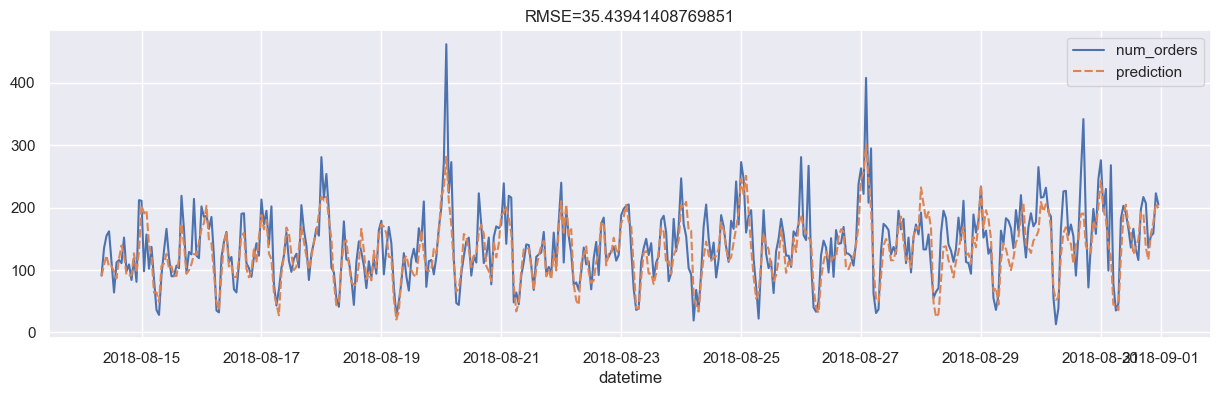

In [24]:
display_result(y_test, y_pred, best_rmse)

## Общий вывод

**В ходе работы над исследованием была обучена, выбрана и протестирована лучшая модель машинного обучения, прогнозирующая количество заказов такси в следующий час. Финальное качество модели на тестовой выборке: `RMSE == 35.43941408769851`** 


Исследование было разделено на несколько этапов:

**1. Загрузка и подготовка данных**


- В данных обнаружили информацию о 26496 заках такси в аэропортах 
- Данные представлены за промежуток с 1 марта 2018 года (0:00) по 31 августа 2018 года (23:50)
- Пропущенных значений не было обнаружено
- С типами данных все оказалось в порядке
- Сразу ресемплировали данные по часам по задаче заказчика 



**2. Общий анализ данных**

- Построили несколько графиков для визуализации данных
- Обнаружили тренд на повышение количества заказов к августу. Вероятно, летний сезон более активный с точки зрения авиаперевозок среди потребителей, в связи с чем заказы в аэропорты учащаются. 
- Минимальное количество заказов ~ в 06:00 (сезонно)
- Максимальное количество заказов ~ в 00:00 (сезонно)
- В течение дня количество заказов примерно среднее, небольшое повышение к вечеру в 16-17 часов. 



**3. Подбор гиперпараметров и обучение моделей**

- Разбили данные на тренировочную и тестовую выборку (9:1)
- Перебрали 3 модели: `LinearRegression`, `RandomForestRegressor` и `CatBoostRegressor`.
- Все модели показали близкий результат метрики RMSE на кросс-валидации, однако в качестве лучшей была признана базовая модель `LinearRegression` 



**5. Тестирование лучшей модели**
- RMSE на тестовой метрики составило **35.43941408769851**, что соответствует критерию успеха от заказчика.
- Визуализировали правильные ответы и предсказанные лучшей моделью ответы. 